In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
import pickle

In [24]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive
folder_path = '/content/drive/My Drive/tomato_combined_balanced_dataset'

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# List the contents of the folder
print("Contents of the folder:")
for item in os.listdir(folder_path):
    print(item)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content
Contents of the folder:
Target_Spot
Yellow_Leaf_Curl_Virus
Septoria_leaf_spot
Leaf_Mold
Mosaic_virus
Healthy
Late_blight
Early_blight
Bacterial_spot


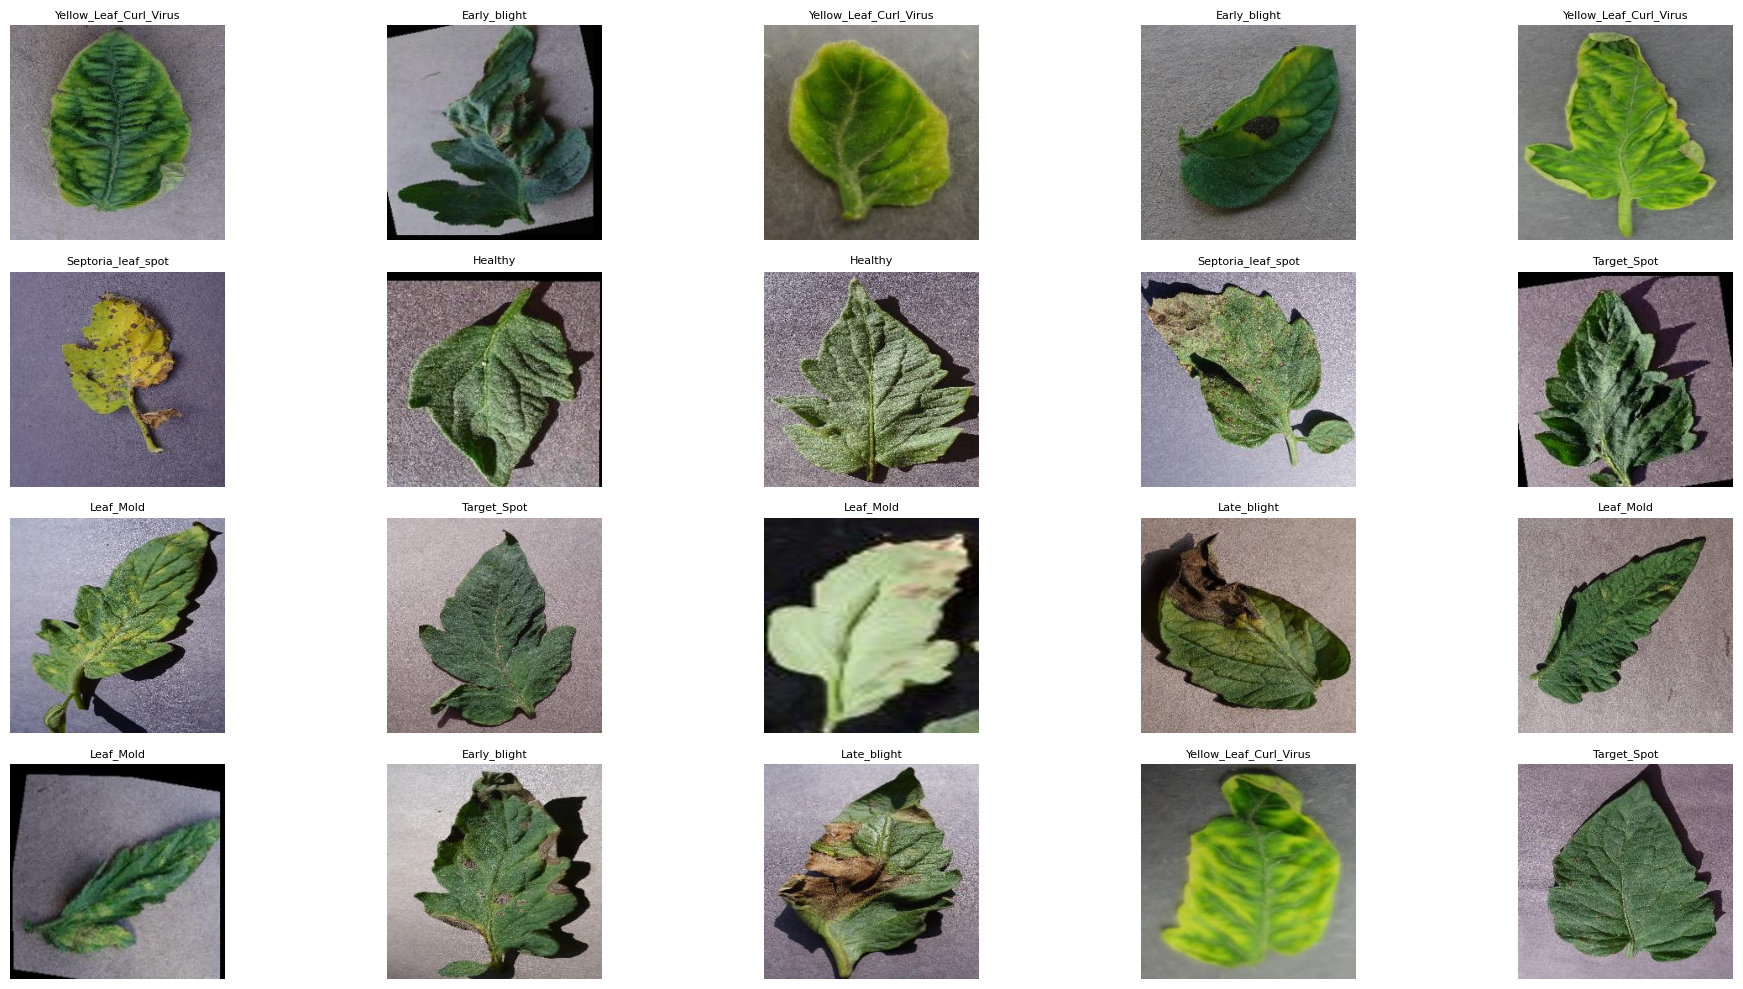

In [25]:
import random
import matplotlib.image as mpimg

data_dir = folder_path

# Collect all image paths with their label (folder name)
image_paths = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append((os.path.join(class_path, fname), class_name))

# Randomly select 20 images
selected_images = random.sample(image_paths, 20)

# Plot the images
plt.figure(figsize=(20, 10))
for idx, (img_path, label) in enumerate(selected_images):
    img = mpimg.imread(img_path)
    plt.subplot(4, 5, idx + 1)
    plt.imshow(img)
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
!cp -r "/content/drive/My Drive/tomato_combined_balanced_dataset" /content/


In [27]:
batch_size = 32
img_height = 224
img_width = 224
seed = 123
data_dir = "/content/tomato_combined_balanced_dataset"

In [28]:
checkpoint_dir = '/content/drive/My Drive/convnext_224_checkpoints'  # Where to save checkpoints

# Create checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# ============== CHECK FOR PREVIOUS TRAINING ==============
checkpoint_info_path = os.path.join(checkpoint_dir, 'training_info.json')
history_path = os.path.join(checkpoint_dir, 'training_history.pkl')

previous_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

if os.path.exists(checkpoint_info_path):
    with open(checkpoint_info_path, 'r') as f:
        info = json.load(f)
        epoch = info['last_epoch']
        print(f"🔄 FOUND PREVIOUS TRAINING - Resuming from epoch {epoch}")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            previous_history = pickle.load(f)
            print(f"📊 Last training metrics:")
            print(f"   Train Accuracy: {previous_history['accuracy'][-1]:.4f}")
            print(f"   Val Accuracy: {previous_history['val_accuracy'][-1]:.4f}")
else:
    print("🆕 Starting fresh training")


🆕 Starting fresh training


In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 18015 files belonging to 9 classes.
Using 14412 files for training.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 18015 files belonging to 9 classes.
Using 3603 files for validation.


In [31]:
num_classes = len(train_ds.class_names)
print("Classes:", train_ds.class_names)

Classes: ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_Mold', 'Mosaic_virus', 'Septoria_leaf_spot', 'Target_Spot', 'Yellow_Leaf_Curl_Virus']


In [32]:
for image_batch, labels in train_ds.take(1):
		print(image_batch.shape)
		print(labels.shape)

(32, 224, 224, 3)
(32,)


In [33]:
train_ds = train_ds.prefetch(2)
test_ds = val_ds.prefetch(2)

# ✅ mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [34]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Added vertical flip
    tf.keras.layers.RandomRotation(0.2),  # Increased from 0.1
    tf.keras.layers.RandomZoom(0.2),  # Increased from 0.1
    tf.keras.layers.RandomContrast(0.2),  # Increased from 0.1
    tf.keras.layers.RandomBrightness(0.2),  # NEW
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # NEW - slight shifts
])

In [35]:
base_model = tf.keras.applications.ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=(img_width, img_height, 3),
        pooling=None  # We'll add custom pooling
    )

In [36]:
base_model.trainable = True

# Optionally freeze first N layers if GPU is weak:
for layer in base_model.layers[:100]:
    layer.trainable = False

In [37]:
    inputs = tf.keras.Input(shape=(img_width, img_height, 3))

    # Data augmentation
    x = data_augmentation(inputs, training=True)

    # Preprocessing
    x = tf.keras.applications.convnext.preprocess_input(x)

    # Base model
    x = base_model(x, training=True)

    # Custom head with more capacity
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)  # Added layer
    x = tf.keras.layers.Dropout(0.4)(x)  # Increased dropout
    x = tf.keras.layers.BatchNormalization()(x)  # Added BN
    x = tf.keras.layers.Dense(256, activation='relu')(x)  # Added layer
    x = tf.keras.layers.Dropout(0.3)(x)

    # Output layer with label smoothing
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)


In [38]:
model = tf.keras.Model(inputs, outputs)

In [39]:
  model.compile(
      optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=["accuracy"]
  )

In [40]:
class SaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, previous_history):
        self.checkpoint_dir = checkpoint_dir
        self.history = previous_history

    def on_epoch_end(self, epoch, logs=None):
        actual_epoch = epoch

        # Update history
        for key in logs:
            if key in self.history:
                self.history[key].append(logs[key])

        # Save model
        model_path = os.path.join(self.checkpoint_dir, f'model_epoch_{actual_epoch+1}.keras')
        self.model.save(model_path)

        # Save just weights too (smaller file)
        weights_path = os.path.join(self.checkpoint_dir, f'weights_epoch_{actual_epoch+1}.weights.h5')

        self.model.save_weights(weights_path)
        info = {
            'last_epoch': actual_epoch,
            'val_accuracy': float(logs['val_accuracy']),
            'train_accuracy': float(logs['accuracy'])
        }
        with open(os.path.join(self.checkpoint_dir, 'training_info.json'), 'w') as f:
            json.dump(info, f)

        # Save history
        with open(os.path.join(self.checkpoint_dir, 'training_history.pkl'), 'wb') as f:
            pickle.dump(self.history, f)

        if actual_epoch > 3:
            old_model = os.path.join(self.checkpoint_dir, f'model_epoch_{actual_epoch-3}.keras')
            old_weights = os.path.join(self.checkpoint_dir, f'weights_epoch_{actual_epoch-3}.weights.h5')
            if os.path.exists(old_model):
                os.remove(old_model)
            if os.path.exists(old_weights):
                os.remove(old_weights)

        print(f"\n💾 Checkpoint saved: Epoch {actual_epoch} - "
              f"Train Acc: {logs['accuracy']:.4f}, Val Acc: {logs['val_accuracy']:.4f}")


In [41]:
history = model.fit(
        train_ds,
        validation_data=test_ds,
        initial_epoch=0,
        epochs=10,
        callbacks=[SaveCallback(checkpoint_dir, previous_history)]
    )

Epoch 1/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7106 - loss: 0.8959
💾 Checkpoint saved: Epoch 0 - Train Acc: 0.8310, Val Acc: 0.9001
451/451 ━━━━━━━━━━━━━━━━━━━━ 356s 618ms/step - accuracy: 0.7109 - loss: 0.8951 - val_accuracy: 0.9001 - val_loss: 0.3311
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9274 - loss: 0.2289
💾 Checkpoint saved: Epoch 1 - Train Acc: 0.9289, Val Acc: 0.9137
451/451 ━━━━━━━━━━━━━━━━━━━━ 204s 354ms/step - accuracy: 0.9274 - loss: 0.2289 - val_accuracy: 0.9137 - val_loss: 0.2758
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9347 - loss: 0.2053
💾 Checkpoint saved: Epoch 2 - Train Acc: 0.9412, Val Acc: 0.9403
451/451 ━━━━━━━━━━━━━━━━━━━━ 197s 343ms/step - accuracy: 0.9347 - loss: 0.2052 - val_accuracy: 0.9403 - val_loss: 0.2106
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9509 - loss: 0.1521
💾 Checkpoint saved: Epoch 3 - Train Acc: 0.9540, Val Acc: 0.9367
451/451 ━━━━━━━━━━━━━━━━━

In [ ]:
history = model.fit(
        train_ds,
        validation_data=test_ds,
        initial_epoch=10,
        epochs=20,
        callbacks=[SaveCallback(checkpoint_dir, previous_history)]
    )

Epoch 11/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9751 - loss: 0.0853
💾 Checkpoint saved: Epoch 10 - Train Acc: 0.9768, Val Acc: 0.9670
451/451 ━━━━━━━━━━━━━━━━━━━━ 155s 345ms/step - accuracy: 0.9751 - loss: 0.0853 - val_accuracy: 0.9670 - val_loss: 0.1528
Epoch 12/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9783 - loss: 0.0724
💾 Checkpoint saved: Epoch 11 - Train Acc: 0.9777, Val Acc: 0.9606
451/451 ━━━━━━━━━━━━━━━━━━━━ 213s 370ms/step - accuracy: 0.9783 - loss: 0.0724 - val_accuracy: 0.9606 - val_loss: 0.1736
Epoch 13/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9770 - loss: 0.0731
💾 Checkpoint saved: Epoch 12 - Train Acc: 0.9786, Val Acc: 0.9598
451/451 ━━━━━━━━━━━━━━━━━━━━ 190s 344ms/step - accuracy: 0.9770 - loss: 0.0731 - val_accuracy: 0.9598 - val_loss: 0.2051
Epoch 14/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9793 - loss: 0.0654
💾 Checkpoint saved: Epoch 13 - Train Acc: 0.9802, Val Acc: 0.9381
451/451 ━━━━━━━━━

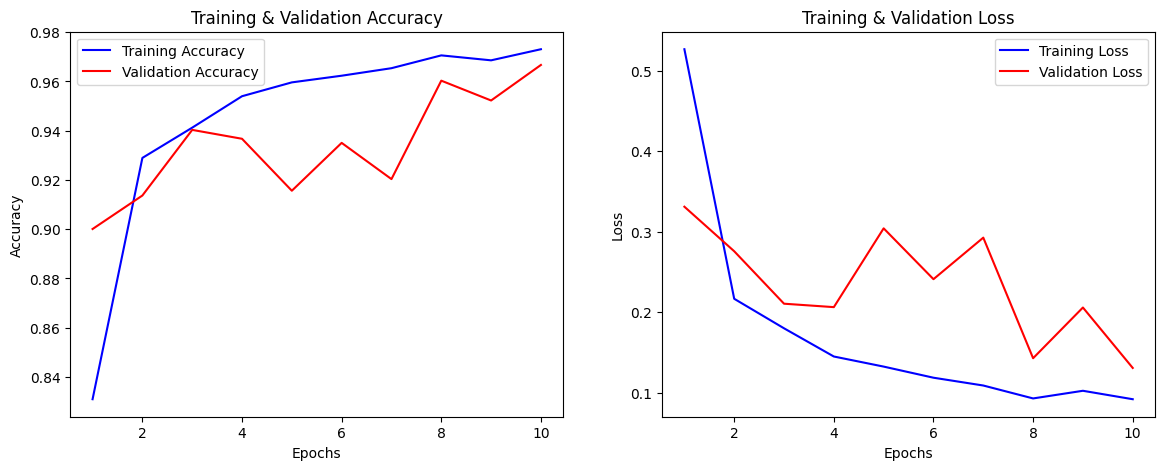

In [42]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import os

history_path = "/content/drive/My Drive/convnext_224_checkpoints/training_history.pkl"


# ---- Load history ----
with open(history_path, "rb") as f:
    history = pickle.load(f)

# ---- Plot training vs validation accuracy and loss ----
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b-", label="Training Accuracy")
plt.plot(epochs, val_acc, "r-", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r-", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [43]:
print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

Final Training Accuracy: 0.9731
Final Validation Accuracy: 0.9667
